<a href="https://colab.research.google.com/github/BDFL669/Data_Analysis_with_R/blob/main/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Outlier Detection
In this article, I focus on 4 examples of outlier detection using R. I will start with univariate outlier detection before providing an example using Local Outlier Factor clustering, and time series outlier detection.

##Univariate Outlier Detection
We sometimes need to detect outliers when we are dealing with a single variable. R provides an elegant method for achieving this task: boxplot.stats(). The function function returns the details (especially the 'out' ccomponent) we use to generate boxplots. The 'out' components contains the entire list of all the outliers in the dataset. We can also use 'coef' argument to change the whisker's boundaries. But that's a story for another day.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.3154 -0.4837  0.1867  0.1098  0.7120  2.6859 

[1] "Outliers:"
[1] -3.315391  2.685922 -3.055717  2.571203


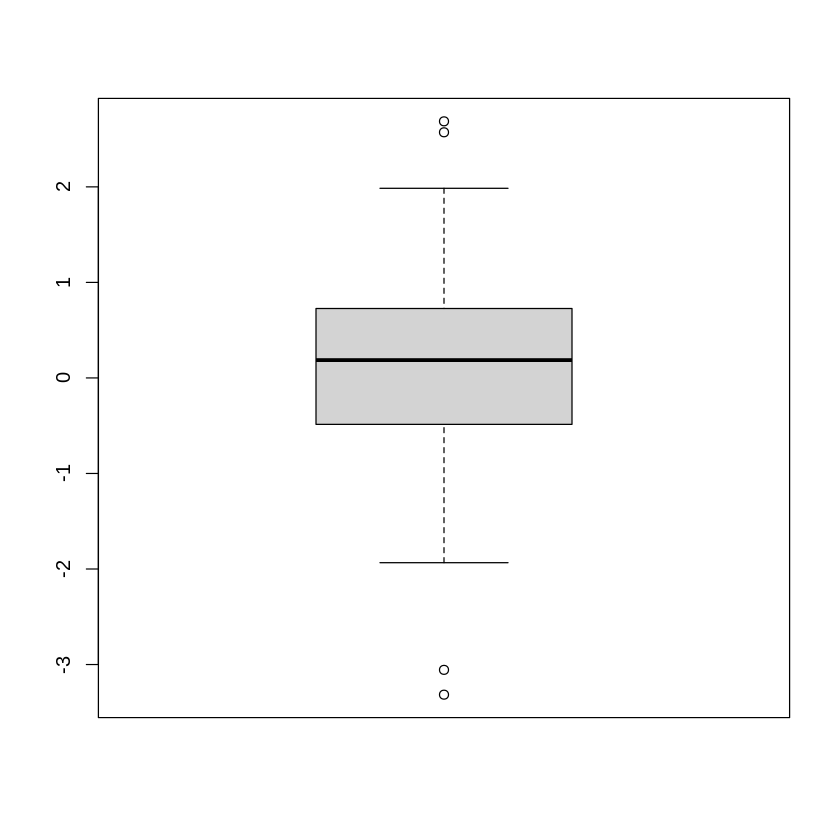

In [ ]:
set.seed(3147)
x <- rnorm(100)
summary(x)
 # outliers
print('Outliers:')
print(boxplot.stats(x)$out)
# plot chart
boxplot(x)

The same univariate outlier detection process is also appropriate for multivariate data. The code below shows how we can use the variables x and y inside a dataframe to detect outliers. We begin by detecting the variables outliers seprately before achieving the same result for both column x and y.

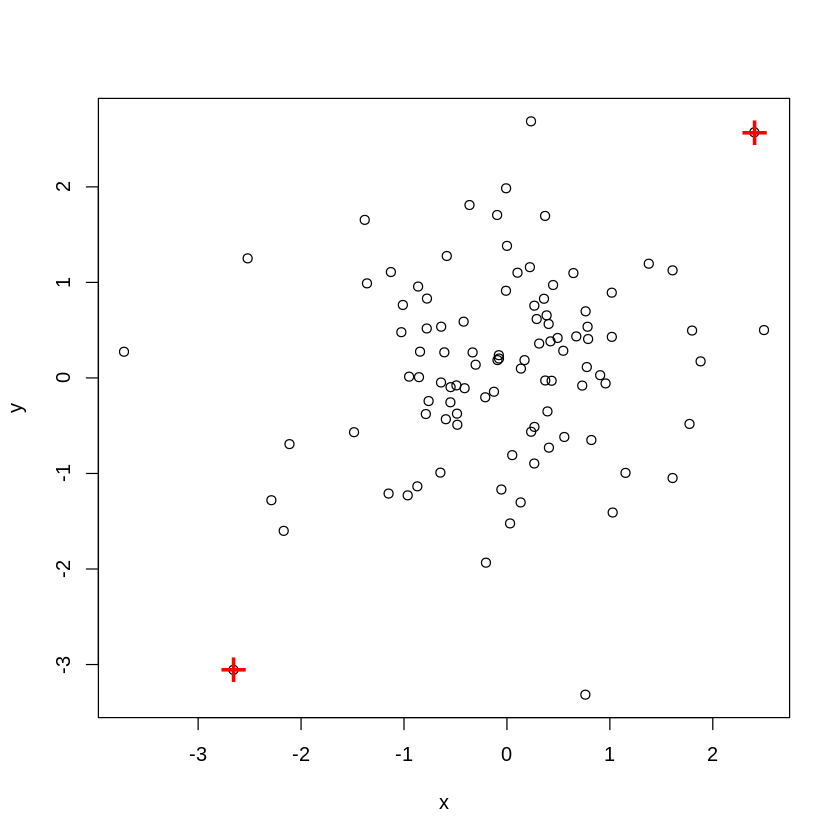

In [ ]:
# Generate data
set.seed(3147)  # For reproducibility
y <- rnorm(100)
x <- rnorm(100)
df <- data.frame(x, y)

# Find the index of outliers from x
outlier_x <- which(x %in% boxplot.stats(x)$out)

# Find the index of outliers from y
outlier_y <- which(y %in% boxplot.stats(y)$out)

# Outliers in both x and y
outlier_list1 <- intersect(outlier_x, outlier_y)

# Plot the data and outliers in red
plot(df)
points(df[outlier_list1, ], col = "red", pch = "+", cex = 2.5)


We can also assume that outliers are any extreme values in eaither column.

[1] 24 25 49 64 74  1 33

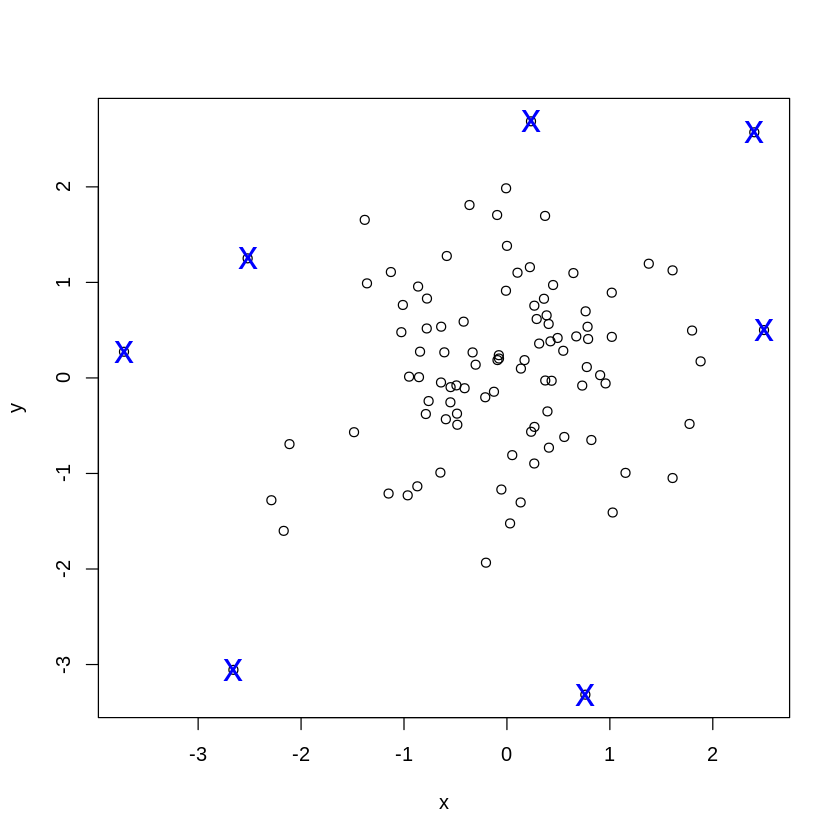

In [ ]:
 # outliers in either x or y
(outlier.list2 <- union(outlier_x, outlier_y))
plot(df)
points(df[outlier.list2,], col="blue", pch="x", cex=2)

##Outlier Detection with LOF
LOF stands for "Local Outlier Factor." It is an unsupervised machine learning algorithm used for outlier detection in datasets. The LOF algorithm quantifies the outlierness of each data point with respect to its local neighborhood. That is, a point's local density is contrasted with neighbors' and the point is regarded as sparse when the LOF value is more than 1 (making it an outlier). LOF is particularly useful when dealing with datasets containing irregularly shaped clusters or non-uniform density distributions. Unfortunately, we can only use this method on numeric data. We use lofactor() to estimate the local outlier factors using R's dprep and DMwR packages. In the example below, we detect the outliers using variable k as number of neighbors used during the calcuatlion. We have also generated a chart of the factor scores.

In [ ]:
#remotes::install_github("cran/DMwR")

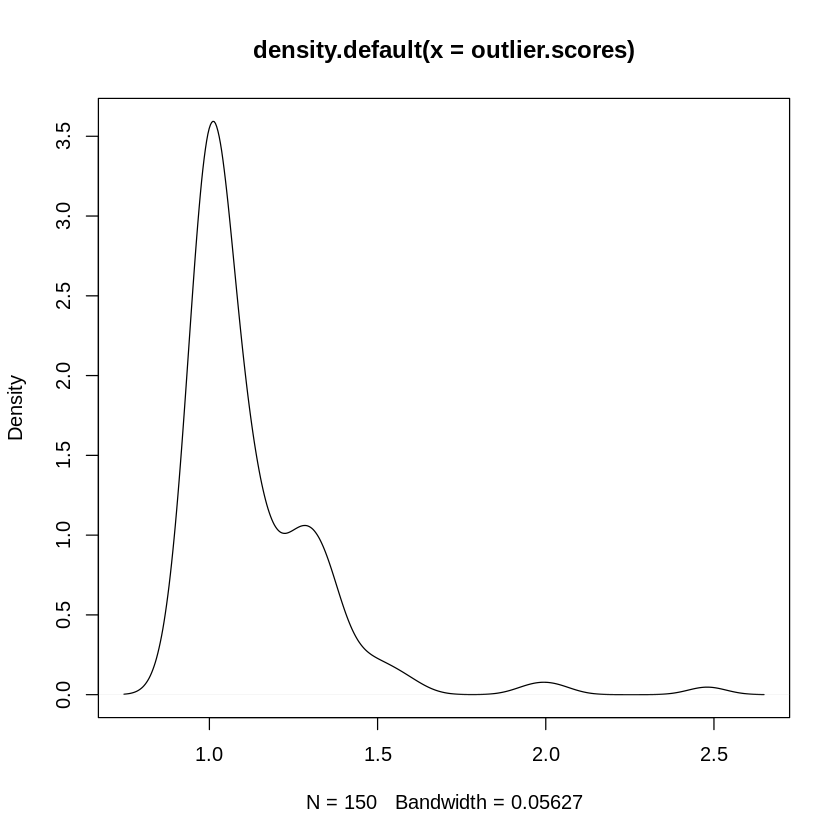

In [ ]:
library(DMwR)
# remove "Species", which is a categorical column
iris2 <- iris[,1:4]
outlier.scores <- lofactor(iris2, k=5)
plot(density(outlier.scores))

In [ ]:
# pick top 5 as outliers
outliers <- order(outlier.scores, decreasing=T)[1:5]
# who are outliers
print(outliers)
print(iris2[outliers,])

[1]  42 107  23 110  63
    Sepal.Length Sepal.Width Petal.Length Petal.Width
42           4.5         2.3          1.3         0.3
107          4.9         2.5          4.5         1.7
23           4.6         3.6          1.0         0.2
110          7.2         3.6          6.1         2.5
63           6.0         2.2          4.0         1.0


Next, we show outliers with a biplot of the first two principal components

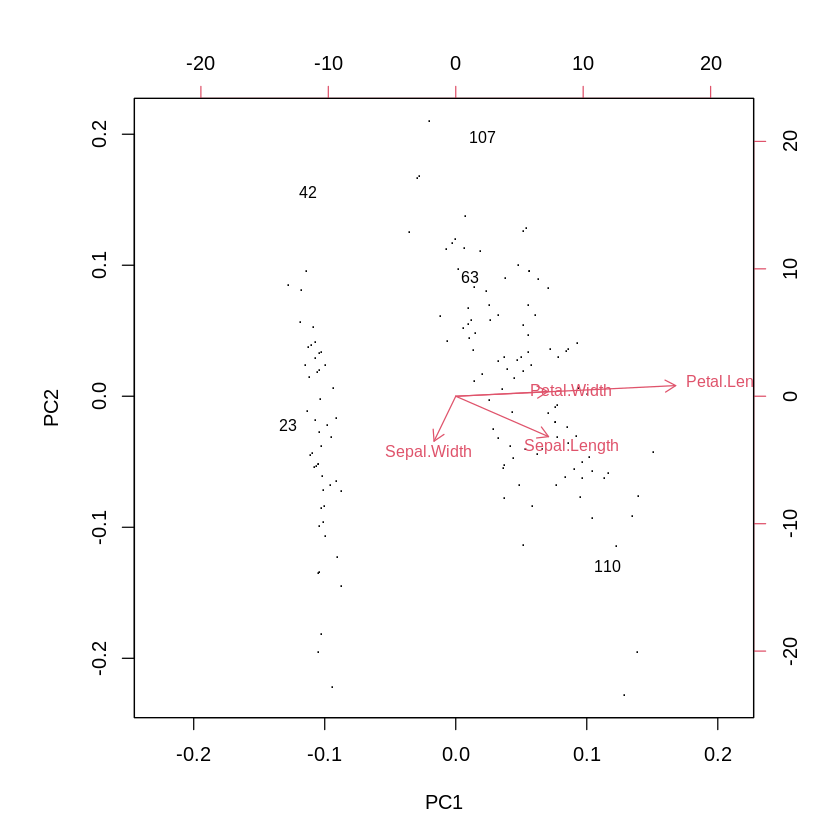

In [ ]:
n <- nrow(iris2)
labels <- 1:n
labels[-outliers] <- "."
biplot(prcomp(iris2), cex=.8, xlabs=labels)


In the code above, we use prcomp() to estimate the principal component analysis and biplot() to generate the chart by ploting the data with the two initial components. Principal Component Analysis (PCA) is a widely used statistical technique in data analysis and dimensionality reduction. It is used to transform high-dimensional data into a lower-dimensional space while preserving as much of the data's original variability as possible. PCA achieves this by finding a new set of orthogonal axes, known as principal components, along which the data has the maximum variance. In the chart above, the x- and y-axis are respectively the first and second principal components, the arrows show the original columns (variables), and the five outliers are labeled with their row numbers.

Additionally, we can visualize outliers using a pairs plot, where we represent outliers with a red "+" symbol. The code is demontrated below:

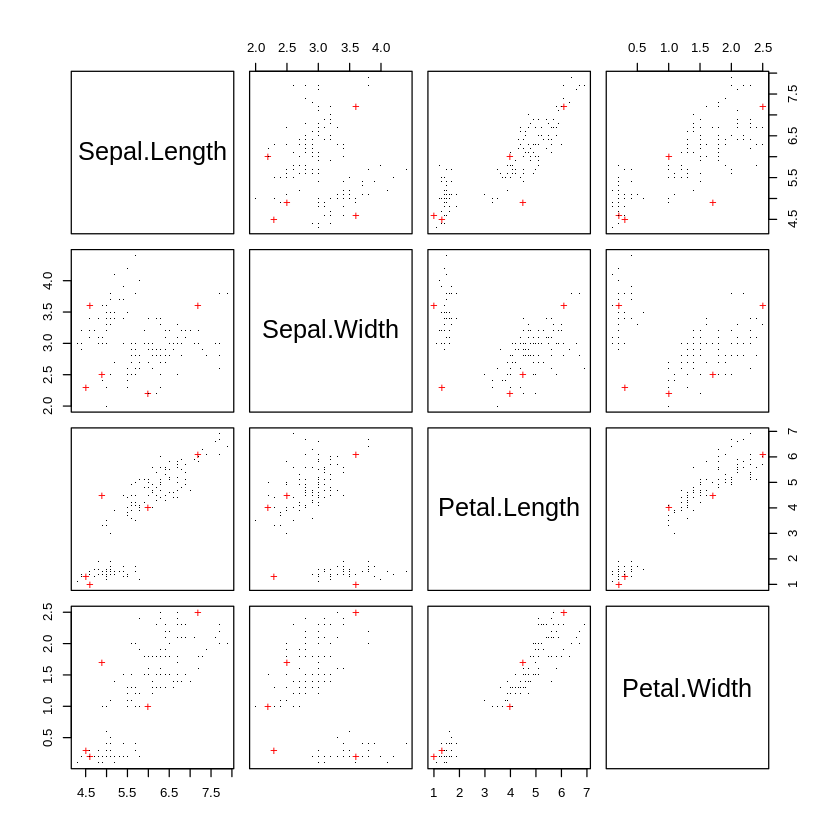

In [ ]:
pch <- rep(".", n)
pch[outliers] <- "+"
col <- rep("black", n)
col[outliers] <- "red"
pairs(iris2, pch=pch, col=col)

Package dbscan has function lof(), an implementation of the LOF
algorithm. While it serves the same function as lofactor(), it also has two extra methods that can leverage multiple k choice distance metrics and values. The following code shows an application of lof(). We first calculate the outliers the detect them by displaying the top values.

In [ ]:
#install.packages("dbscan")

In [ ]:
library(dbscan)

# Assuming iris2 is your data
# Replace this with your actual dataset
data <- iris2

# List to store LOF scores for different minPts values
lof_scores_list <- list()

# Values of minPts to try
minPts_values <- 5:10

# Calculate LOF scores for each value of minPts
for (minPts in minPts_values) {
  lof_scores <- lof(data, minPts = minPts)
  lof_scores_list[[as.character(minPts)]] <- lof_scores
}

# Access the LOF scores for minPts = 5, for example
lof_scores_minPts5 <- lof_scores_list[["5"]]
head(lof_scores_minPts5)

[1] 0.9624149 0.9980281 1.1244614 0.9473478 1.0768750 1.1900530

##Outlier Detection by Clustering
When we cluster data, all the datapoints that do not belong to a specific group or category are automatically regarded as outliers. A good example is how DBSCAN's density-based clustering group objects into a single cluster is they belong the same densely populated area. As a result, an object that is not assigned a cluster are assumed to be outliers due to their isolation.

However, in this section, we will use the k-means algorithm to achieve our goal as demonstrated in the code below. We first partition our data into k groups by placing the datapoints closest to their cluster centers. The next step is to estimate the dissimilairt (distance) between every item and their cluster centers to identify the ones with the largest distance values.

In [ ]:
# remove species from the data to cluster
iris2 <- iris[,1:4]
kmeans.result <- kmeans(iris2, centers=3)
# cluster centers
kmeans.result$centers

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
1,5.901613,2.748387,4.393548,1.433871
2,6.850000,3.073684,5.742105,2.071053
3,5.006000,3.428000,1.462000,0.246000


In [ ]:
 # cluster IDs
kmeans.result$cluster

[1] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
[112] 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
[149] 2 1

In [ ]:
#calculate distances between objects and cluster centers
centers <- kmeans.result$centers[kmeans.result$cluster, ]
distances <- sqrt(rowSums((iris2 - centers)^2))
# pick top 5 largest distances
outliers <- order(distances, decreasing=T)[1:5]
# who are outliers
print(outliers)

[1]  99  58  94  61 119


##Outlier Detection from Time Series
We will now use a time series dataset for the purspoe of outlier detection. We begin by decomposing the data using function stl's robust regression methodology. The process is also known as robust fitting, and it allows us to to identify the outliers. Check out http://cs.wellesley.edu/~cs315/Papers/stl%20statistical%20model if you wanna learn more about STL.

[1]  79  91  92 102 103 104 114 115 116 126 127 128 138 139 140

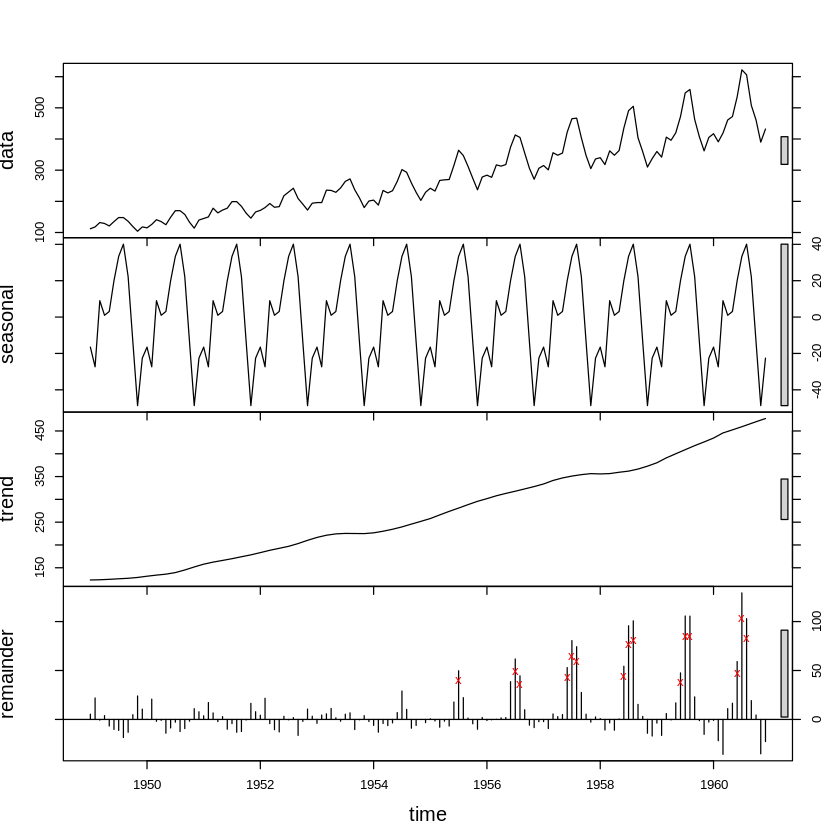

In [ ]:
 # use robust fitting
f <- stl(AirPassengers, "periodic", robust=TRUE)
(outliers <- which(f$weights<1e-8))
op <- par(mar=c(0, 4, 0, 3), oma=c(5, 0, 4, 0), mfcol=c(4, 1))
plot(f, set.pars=NULL)
sts <- f$time.series
# plot outliers
points(time(sts)[outliers], 0.8*sts[,"remainder"][outliers], pch="x", col="red")
par(op) # reset layout


If you made it this far, the least I could do is offer you a veritable easter egg in the form of a book quote:

"Mario, what do you get when you cross an insomniac, an unwilling agnostic and a dyslexic?"

"I give."

"You get someone who stays up all night torturing himself mentally over the question of whether or not there's a dog."


David Foster Wallace - Infinite Jest